**GOAL:** Predict if a user will churn (i.e. fail to make a new service subscription 30 days after expiration date) in the month of April, 2017

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np

1. Competition Description
2. Load Data
3. Clean Data & EDA 
4. Build Predictive Model
5. Discussion
6. Model Submission

# 1. Competition Description

KKBOX offers a subscription based music streaming service. Customers can either auto-renew or choose to renew manually each month. Users can also choose to cancel their membership at anytime. Therefore, the definition of churn is a bit tricky. The competition hosts chose to define a member as having **churned if there is no new valid subscription 30 days after the current membership expires, even if the user chooses to cancel**. 

# 2. Load Data

Competition files:
* members_v3.csv: customer information (age, city, etc.)
* transactions_v2.csv: transactions until 3/31/2017 (ONLY month of March 2017)
* transactions.csv: transactions of users up until 2/28/2017
* train_v2.csv: customers that churn in April 2017
* train.csv: customers that churn in March 2017
* user_logs.csv: users that churn in  March 2017 (num_25-num100: # of songs played < 25% of song length, # of songs played >98.5% of song length)
* user_logs_v2.csv: users that churn in April 2017 

In [3]:
members = pd.read_csv('members_v3.csv')

# transactions = pd.read_csv('transactions.csv') #March 2017
# transactions_v2 = pd.read_csv('transactions_v2.csv') #April 2017
# transactions_all = pd.concat([transactions, transactions_v2])
# del transaction, transactions_v2

#train = pd.read_csv('train.csv')
train_v2 = pd.read_csv('train_v2.csv') 

# user_logs = pd.read_csv('user_logs.csv',nrows = 1e6) #March 2017
# user_logs_v2 = pd.read_csv('user_logs_v2.csv') #April 2017
# user_logs_all = pd.concat([user_logs, user_logs_v2])
# del user_logs, user_logs_v2

#add features to training data
train_merged = pd.merge(left=train_v2, right=members, how='left', on=['msno'])
#train_merged = pd.merge(left=train_merged, right=transactions_all, how='left', on=['msno'])
del train_v2, members

In [4]:
train_merged.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,male,3.0,20131223.0
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,20.0,male,3.0,20131223.0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,18.0,male,3.0,20131227.0
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1.0,0.0,NaN,7.0,20140109.0
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,35.0,female,7.0,20140125.0


# 3. Clean Data & EDA

For each variable:
* Check missing %

In [25]:
print("Percent Missing: ")
train_merged.isnull().sum()/len(train_merged) * 100

Percent Missing: 


msno                       0.000000
is_churn                   0.000000
city                      11.328273
bd                        11.328273
gender                    59.946342
registered_via            11.328273
registration_init_time    11.328273
dtype: float64

* Look for outliers

In [6]:
print(train_merged.describe())

            is_churn           city             bd  registered_via  \
count  970960.000000  860967.000000  860967.000000   860967.000000   
mean        0.089942       5.937295      13.583854        6.892744   
std         0.286099       6.441203      20.064040        1.937794   
min         0.000000       1.000000   -3152.000000        3.000000   
25%         0.000000       1.000000       0.000000        7.000000   
50%         0.000000       1.000000       0.000000        7.000000   
75%         0.000000      13.000000      27.000000        9.000000   
max         1.000000      22.000000    2016.000000       13.000000   

       registration_init_time  
count            8.609670e+05  
mean             2.013265e+07  
std              3.011174e+04  
min              2.004033e+07  
25%              2.012021e+07  
50%              2.014060e+07  
75%              2.016012e+07  
max              2.017042e+07  


Observations: 
* We can see that except for the target is_churn, every other column contains missing values. 
* The bd (i.e. age) column contains outliers on both ends - min age of -3152 and max age of 2016.  

Let's define a helper function. It will take in a dataframe as well as column name and output the frequency of each value of that column. 

In [3]:
def check_distribution(df,col):
    counts = df[col].value_counts(dropna=False)
    percentages = counts / len(df) * 100
    df_percentages = pd.DataFrame({col:percentages.index.values,'count':counts.values,'percent':percentages.values})
    return df_percentages

## Target: is_churn

In [49]:
check_distribution(train_merged,'is_churn')

,is_churn,count,percent
0,0,883630,91.005809
1,1,87330,8.994191


The **churn rate** is only **9%**. That means the **baseline performance** based on the most prevalant class is **91%**. We will have to keep that in mind when evaluating the accuracy of our predictive models. 

## Age

Since the age for typical subscription services is right around 13 years of age, we can create intelligent buckets to see if we have outliers. 

In [28]:
print("Ages < 0 : {}".format((train_merged.bd < 0).sum()))
print("Ages = 0 : {}".format((train_merged.bd == 0).sum()))
print("0 < Ages < 13 : {}".format(((train_merged.bd > 0)&(train_merged.bd < 13)).sum()))
print("13 <= Ages < 100 : {}".format(((train_merged.bd >= 13)&(train_merged.bd < 100)).sum()))
print("Ages > 100 : {}".format((train_merged.bd >= 100).sum()))

Ages < 0 : 69
Ages = 0 : 473729
0 < Ages < 13 : 146
13 <= Ages < 100 : 386558
Ages > 100 : 465


AHA! We can see that there were some **sneaky missing values stored as 0**. Additionally, we have some unrealistic ages below zero as well as a few above 100. Let's cap age to (0,100] and treat everything else as missing.  

In [6]:
#cap age
train_merged['bd'].mask(((train_merged.bd<=0)|(train_merged.bd>100)), other=np.NaN, inplace=True)

In [264]:
print("Percent of age that is missing: {}%".format(int(100 * train_merged.bd.isnull().sum()/len(train_merged))))

Percent of age that is missing: 60%


Text(0.5, 1.0, 'Distribution of (cleaned) Age')

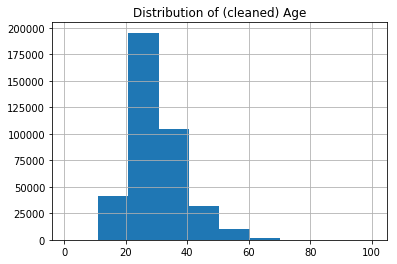

In [43]:
train_merged.bd.hist()
plt.title('Distribution of (cleaned) Age')

This looks like the typical right-skewed distribution of age that we expect where most of the users are under 40. We can further look at the target distribution between each age bucket to see if we are missing value by not targeting particular age groups.

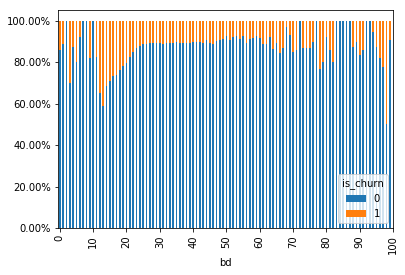

In [258]:
age_crosstab = pd.crosstab(train_merged.bd,train_merged.is_churn)
age_crosstab = age_crosstab.div(age_crosstab.sum(1), axis=0)
ax = age_crosstab.plot(kind='bar', stacked=True)
plt.xticks(ticks=np.arange(0,110,step=10), labels=np.arange(0,110,step=10)) # np.arange(0,110,step=10)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

From the stacked bar plot we can see that 10-24 year-old's churn a lot more than the rest of the population. Since they represent a large portion of the population, later we will dig into any bivariate interactions that might be present. This will help us understand how we can get more value from this particular customer segment. 

Note: there is noise at the edges of the bar plot because we have such few observations in those particular age buckets. 

## Gender

In [96]:
check_distribution(train_merged,'gender')

,gender,count,percent
0,NaN,582055,59.946342
1,male,204561,21.067912
2,female,184344,18.985746


A majority of the gender is missing but there don't seem to be any outlier values that we need to deal with. Since over half the values are missing, we can't simply drop values. Either we can impute or simply **use tree based algorithms** that can treat NaN as a special value.

Let's check to see if there are different churn rates for each gender.

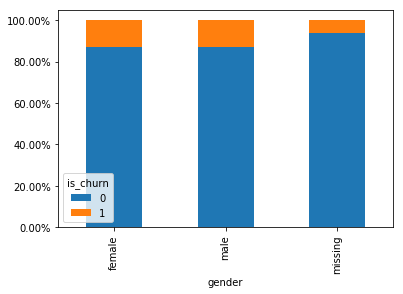

In [218]:
gender_crosstab = pd.crosstab(train_merged.gender.fillna('missing'),train_merged.is_churn, dropna=False)
gender_crosstab = gender_crosstab.div(gender_crosstab.sum(1), axis=0)
ax = gender_crosstab.plot(kind='bar', stacked=True)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

In [137]:
gender_crosstab

is_churn,0,1
gender,,
female,0.870134,0.129866
male,0.870963,0.129037
missing,0.936442,0.063558


Both genders have a churn rate of 13%. The group with gender missing has a characteristically lower churn rate of 6.4%.

## City

In [134]:
check_distribution(train_merged,'city')

,city,count,percent
0,1.0,442598,45.583546
1,NaN,109993,11.328273
2,13.0,97136,10.004120
3,5.0,70706,7.282071
4,4.0,47227,4.863949
5,15.0,43187,4.447866
6,22.0,41991,4.324689
7,6.0,26066,2.684560
8,14.0,20013,2.061156
9,12.0,11383,1.172345


**11%** of the values are **missing** for the city variable. It looks like  most of the customers come from city 1. 

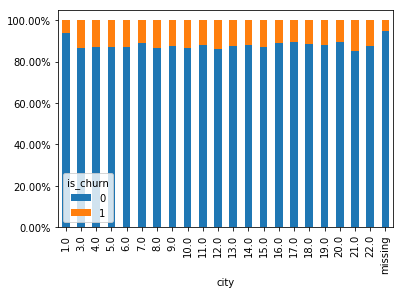

In [217]:
city_crosstab = pd.crosstab(train_merged.city.fillna('missing'),train_merged.is_churn, dropna=False)
city_crosstab = city_crosstab.div(city_crosstab.sum(1), axis=0)
ax = city_crosstab.plot(kind='bar', stacked=True)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

Most of the cities have very similar churn rates. 

## Registration_via

In [141]:
check_distribution(train_merged,'registered_via')

,registered_via,count,percent
0,7.0,462684,47.652220
1,9.0,235689,24.273811
2,NaN,109993,11.328273
3,3.0,106459,10.964303
4,4.0,52744,5.432150
5,13.0,3391,0.349242


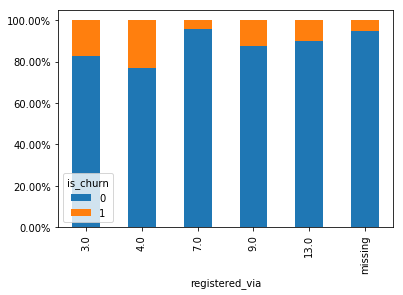

In [216]:
registration_crosstab = pd.crosstab(train_merged.registered_via.fillna('missing'),train_merged.is_churn, dropna=False)
registration_crosstab = registration_crosstab.div(registration_crosstab.sum(1), axis=0)
ax = registration_crosstab.plot(kind='bar', stacked=True)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

In [143]:
registration_crosstab

is_churn,0,1
registered_via,,
3.0,0.827746,0.172254
4.0,0.768978,0.231022
7.0,0.955268,0.044732
9.0,0.873168,0.126832
13.0,0.901209,0.098791
missing,0.946524,0.053476


Since we don't know what the numerical codes mean, the best insight we can derive is that we need to focus on registration_via = 4 to see why we have such a high churn rate for that category.

## Registration_init_time

In [7]:
# convert from int to datetime
train_merged['registration_init_time'] = train_merged['registration_init_time'].apply(lambda x: pd.to_datetime(x,format="%Y%m%d"))

Let's do some **feature engineering** and create a variable called **days_since_registration**. It will the number of days between the date the records were pulled (04/30/2017) and the registration date.

In [8]:
timedelta = pd.to_datetime(20170430,format="%Y%m%d") - train_merged.registration_init_time
train_merged['days_since_registration'] = [item.days for item in timedelta]
train_merged['months_since_registration'] = train_merged.days_since_registration / 30
train_merged['years_since_registration'] = train_merged.days_since_registration / 365

Text(0.5, 0, 'Years Since Registration')

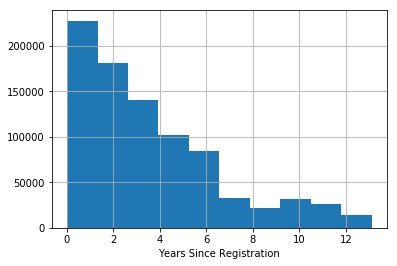

In [212]:
train_merged.years_since_registration.hist()
plt.xlabel('Years Since Registration')

In [8]:
bins = range(0,int(max(train_merged.years_since_registration)))
train_merged['years_since_reg_bin'] = pd.cut(train_merged.years_since_registration.fillna(-1), bins=bins)

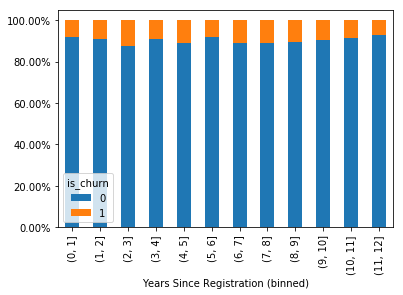

In [252]:
registration_crosstab = pd.crosstab(train_merged.years_since_reg_bin,train_merged.is_churn, dropna=False)
registration_crosstab = registration_crosstab.div(registration_crosstab.sum(1), axis=0)
ax = registration_crosstab.plot(kind='bar', stacked=True)
plt.xlabel('Years Since Registration (binned)')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

There is no clear trend in the churn rate at the yearly level. Since this is a monthly subscription service, it makes sense to dive deeper to the monthly churn rate since registration.

In [9]:
bins = range(0,int(max(train_merged.months_since_registration)))
train_merged['months_since_reg_bin'] = pd.cut(train_merged.months_since_registration.fillna(-1), bins=bins)

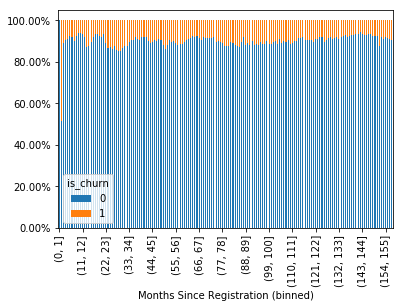

In [254]:
registration_crosstab = pd.crosstab(train_merged.months_since_reg_bin,train_merged.is_churn, dropna=False)
registration_crosstab = registration_crosstab.div(registration_crosstab.sum(1), axis=0)
ax = registration_crosstab.plot(kind='bar', stacked=True)
ax.set_xticklabels(ax.get_xticklabels()[::11])
ax.set_xticks(ax.get_xticks()[::11])
plt.xlabel('Months Since Registration (binned)')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

In [251]:
registration_crosstab.head(n=12)

is_churn,0,1
months_since_reg_bin,,
"(0, 1]",1.000000,0.000000
"(1, 2]",0.513823,0.486177
"(2, 3]",0.891644,0.108356
"(3, 4]",0.903808,0.096192
"(4, 5]",0.911775,0.088225
"(5, 6]",0.926267,0.073733
"(6, 7]",0.921051,0.078949
"(7, 8]",0.899379,0.100621
"(8, 9]",0.924297,0.075703


Nobody churns in the first 30 days since the subscription lasts 30 days. **50% of the users churn after the first month**. After that, the churn rate drops off dramaticaly.  

# 4. Build Predictive Model

In [3]:
from sklearn.linear_model import LogisticRegression

In [10]:
train_merged.dtypes

msno                                 object
is_churn                              int64
city                                float64
bd                                  float64
gender                               object
registered_via                      float64
registration_init_time       datetime64[ns]
days_since_registration             float64
months_since_registration           float64
years_since_registration            float64
years_since_reg_bin                category
months_since_reg_bin               category
dtype: object

We need to change the data type for city, gender and registered_via into category from float64 since moving from one level to the next has no inherent concept of distance - which is what having a float value would imply.

In [11]:
train_merged['city'] = train_merged.city.fillna('missing')
train_merged['gender'] = train_merged.gender.fillna('missing')
train_merged['registered_via'] = train_merged.registered_via.fillna('missing').astype(int,errors='ignore')

In [12]:
keep_columns = ['is_churn','city','bd','gender','registered_via','days_since_registration']
train_merged = train_merged[keep_columns]

### One-hot encoding & handling missing data

In [13]:
# One-Hot Encode categorical variables
train_merged = pd.get_dummies(train_merged,columns=['gender','city','registered_via'], 
               prefix=['bin_gender','bin_city','bin_registered_via'], drop_first=True)

# Imputation using Median and isnull feature for numeric columns
train_merged['bin_bd_missing'] = train_merged.bd.isnull().astype(int)
train_merged.bd.fillna(train_merged.bd.mode()[0],inplace=True)

train_merged['bin_days_since_registration_missing'] = train_merged.days_since_registration.isnull().astype(int)
train_merged.days_since_registration.fillna(train_merged.days_since_registration.mode()[0],inplace=True)

In [51]:
train_merged.columns

Index(['is_churn', 'bd', 'days_since_registration', 'bin_gender_male',
       'bin_gender_missing', 'bin_city_3.0', 'bin_city_4.0', 'bin_city_5.0',
       'bin_city_6.0', 'bin_city_7.0', 'bin_city_8.0', 'bin_city_9.0',
       'bin_city_10.0', 'bin_city_11.0', 'bin_city_12.0', 'bin_city_13.0',
       'bin_city_14.0', 'bin_city_15.0', 'bin_city_16.0', 'bin_city_17.0',
       'bin_city_18.0', 'bin_city_19.0', 'bin_city_20.0', 'bin_city_21.0',
       'bin_city_22.0', 'bin_city_missing', 'bin_registered_via_4.0',
       'bin_registered_via_7.0', 'bin_registered_via_9.0',
       'bin_registered_via_13.0', 'bin_registered_via_missing',
       'bin_bd_missing', 'bin_days_since_registration_missing'],
      dtype='object')

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score,confusion_matrix,roc_curve
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

Before proceeding to build a model, we need to create a proper test set.

In [15]:
X = train_merged[train_merged.columns[1:]]
y = train_merged[train_merged.columns[:1]]
# X.to_csv('X.csv')
# y.to_csv('y.csv')

In [5]:
X = pd.read_csv('X.csv',index_col=0)
y = pd.read_csv('y.csv',index_col=0)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=22)

### Logistic Regression

Let's check the correlation between our inputs to see if we need to address it. 

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5]),
 <a list of 32 Text xticklabel objects>)

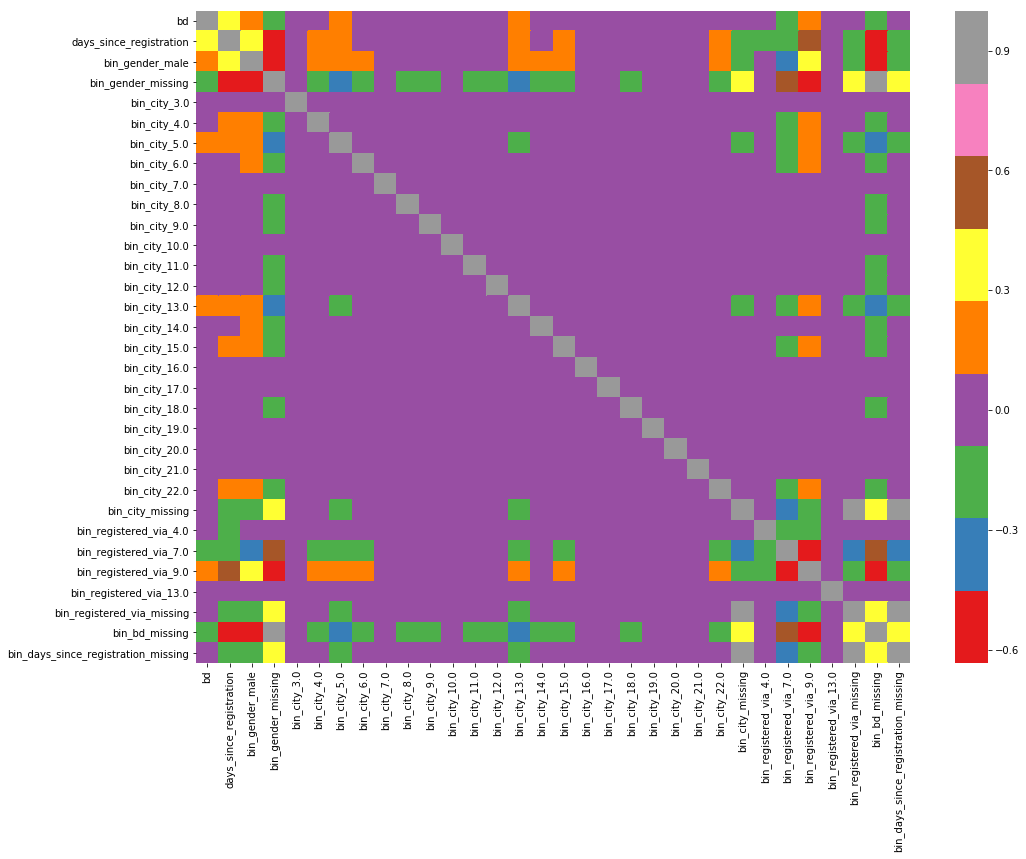

In [7]:
# plot the heatmap of correlations
corr = X_train.corr()

plt.figure(figsize=(16,12))
sns.heatmap(corr,cmap='Set1',annot=False)
plt.xticks(rotation=90)

Whenever gender is missing, age is also missing. Similarly, there are some other high correlations between our inputs that need to be addressed before proceeding to modeling.

[**Multicollinearity**](https://en.wikipedia.org/wiki/Multicollinearity) can be checked using the concept of [**variance inflation factor**](https://en.wikipedia.org/wiki/Variance_inflation_factor)(VIF). We don't want our variables to be correlated because the estimates of our coefficients would vary wildly and this would affect the interpretability of our model. Variance inflation factor is a measure of how much the variance of an estimated coefficient is increased because of collinearity. Values of VIF above 10 are considered high.

Let's write a function to recursively remove columns from our dataframe that have the highest VIF until the maximum VIF is under 10 so we can begin modeling.

In [8]:
def uncorrelate_using_vif(X, thresh=10.0):
    # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
    dropped=True
    while dropped:
        variables = X.columns
        dropped = False
        vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]

        max_vif = max(vif)
        if max_vif > thresh:
            maxloc = vif.index(max_vif)
            print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
            X = X.drop([X.columns.tolist()[maxloc]], axis=1)
            dropped=True
    return X

In [9]:
X_train = uncorrelate_using_vif(X_train)

/home/crashoverride/anaconda3/envs/nn_cv/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping bin_city_missing with vif=inf
Dropping bin_registered_via_missing with vif=inf
Dropping bin_gender_missing with vif=30.45967407294448
Dropping bd with vif=17.141709122413193


Let's write a function that takes in a machine learning model with some training data and outputs the roc curve as well as score.

In [75]:
def calc_roc_stats(model,mode='train',X=X_train,y=y_train,verbose=1):
    '''
    Parameters
    -------
    model: Machine Learning model (sklearn)
    mode: 'train' or 'test'
    X: dataframe of independent variables
    y: dataframe of dependent variable
    verbose: boolen, if true, print accuracy and AUC
    Returns
    -------
    model: fitted model
    false positive rate: array of increasing false positive rates
    true positive rate: array of increasing true positive rates
    auc: area under the ROC curve
    '''
    
    if mode == 'train':
        model.fit(X,y)
    y_hat = model.predict_proba(X)[:,1] #[P(0),P(1)]
    fp,tp,th = roc_curve(y,y_hat)
    auc = roc_auc_score(y,y_hat)
    
    if verbose:
        print("Mean accuracy: {:0.2f}".format(model.score(X,y)))
        print("AUC: {:0.2f}".format(auc))
    
    return model,fp,tp,auc

In [76]:
log_reg = LogisticRegression(class_weight="balanced",solver='lbfgs',penalty='l2')
log_reg,fp_logreg,tp_logreg,auc_logreg = calc_roc_stats(model=log_reg)

/home/crashoverride/anaconda3/envs/nn_cv/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/crashoverride/anaconda3/envs/nn_cv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Mean accuracy: 0.63
AUC: 0.68


In [12]:
#Get model coefficients
logreg_coef = pd.DataFrame({'column':X_train.columns.values,
                           'coefficient':log_reg.coef_.transpose().flatten()})
logreg_coef['exp(coefficient)'] = logreg_coef.coefficient.apply(lambda x: np.exp(x))

In [13]:
logreg_coef.sort_values(by='column')

,column,coefficient,exp(coefficient)
26,bin_bd_missing,-0.346625,0.707070
9,bin_city_10.0,0.045105,1.046138
10,bin_city_11.0,-0.009299,0.990744
11,bin_city_12.0,0.091652,1.095983
12,bin_city_13.0,0.004913,1.004926
13,bin_city_14.0,0.030997,1.031482
14,bin_city_15.0,0.057587,1.059277
15,bin_city_16.0,-0.002110,0.997892
16,bin_city_17.0,-0.023653,0.976625
17,bin_city_18.0,0.010285,1.010338


These coefficients represent log odds. We need to exponentiate them and compare to the base class for each variable to see whether we have a higher likelihood of churning. Here are some examples of insights for the most important variables to help clarify the interpretation:
* When customers sign up via method 4, their odds of churning are 2.28 as compared to the base class for registration, which is method 13 - barring all other inputs are held constant. Therefore, the **odds of customers churning are 128% higher for registration method 4 when compared to registration method 13**. KKBOX should further investigate into reducing the churn rate for users registered via method 4.
* Similarly, users who register via method 7 have odds of 0.34 of churning when compared to the base class of registering via method 13. This means the **odds of customers churning are 66% lower for method 7 when compared to the odds of registering via method 13**.
* If registration date is missing, then the odds of churning are 60% lower.
* If the **user is male, the odds of churning are 9% lower** when compared to the odds of churning as a female.

### Decision Tree

In [14]:
#address overfitting
min_examples = int(0.01 * len(X_train))# at least 1% of data in leaf
min_examples

6796

In [77]:
tree = DecisionTreeClassifier(class_weight="balanced",min_samples_leaf=min_examples)
tree,fp_dt,tp_dt,auc_dt = calc_roc_stats(model=tree)

Mean accuracy: 0.62
AUC: 0.73


### Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [78]:
rf = RandomForestClassifier(min_samples_leaf=min_examples, random_state=22, class_weight="balanced")
rf,fp_rf,tp_rf,auc_rf = calc_roc_stats(model=rf)

/home/crashoverride/anaconda3/envs/nn_cv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/crashoverride/anaconda3/envs/nn_cv/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Mean accuracy: 0.60
AUC: 0.71


### SVM

In [23]:
# Runtime complexity: O(N^2)

# from sklearn import svm
# clf = svm.SVC(class_weight="balanced")
# clf.fit(X_train,y_train)
# y_hat_svm = clf.predict_proba(X_test)[:,1]
# fp_svm, tp_svm, th_svm = roc_curve(y_test,y_hat_svm)
# auc_svm = roc_auc_score(y_test,y_hat_svm)

### Naive Bayes

In [65]:
from sklearn.naive_bayes import GaussianNB
from matplotlib.lines import Line2D

In [79]:
clf = GaussianNB()
clf,fp_nb,tp_nb,auc_nb = calc_roc_stats(model=clf)

/home/crashoverride/anaconda3/envs/nn_cv/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean accuracy: 0.78
AUC: 0.66


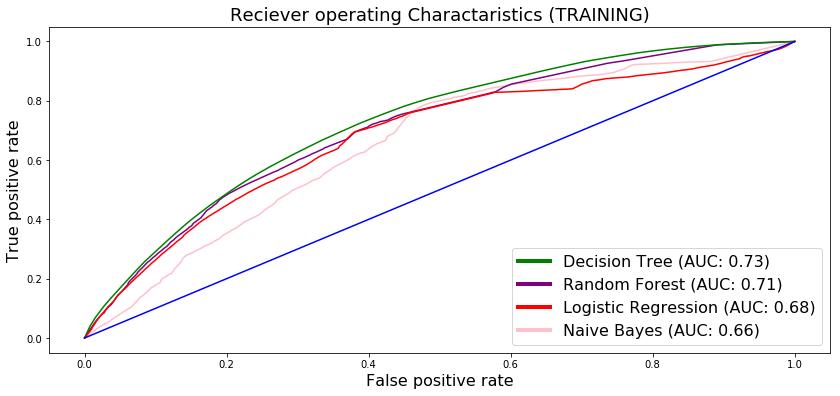

In [80]:
plt.figure(figsize=(14,6))
plt.plot(fp_nb,tp_nb,color='pink')
plt.plot(fp_rf,tp_rf,color='purple')
plt.plot(fp_dt,tp_dt,color='g')
plt.plot(fp_logreg,tp_logreg,color='r')
plt.plot([0,1],[0,1],color='b')
plt.title('Reciever operating Charactaristics (TRAINING)', fontsize=18)
plt.xlabel('False positive rate', fontsize=16)
plt.ylabel('True positive rate', fontsize=16)

#custom legend
legend_elements = [Line2D([0], [0], color='g', lw=4, label='Decision Tree (AUC: {:0.2f})'.format(auc_dt)),
                   Line2D([0], [0], color='purple', lw=4, label='Random Forest (AUC: {:0.2f})'.format(auc_rf)),
                   Line2D([0], [0], color='r', lw=4, label='Logistic Regression (AUC: {:0.2f})'.format(auc_logreg)),
                   Line2D([0], [0], color='pink', lw=4, label='Naive Bayes (AUC: {:0.2f})'.format(auc_nb))]
plt.legend(handles=legend_elements,loc='lower right', fontsize=16)

Let's see how well our models generalize by predicting on the test data.

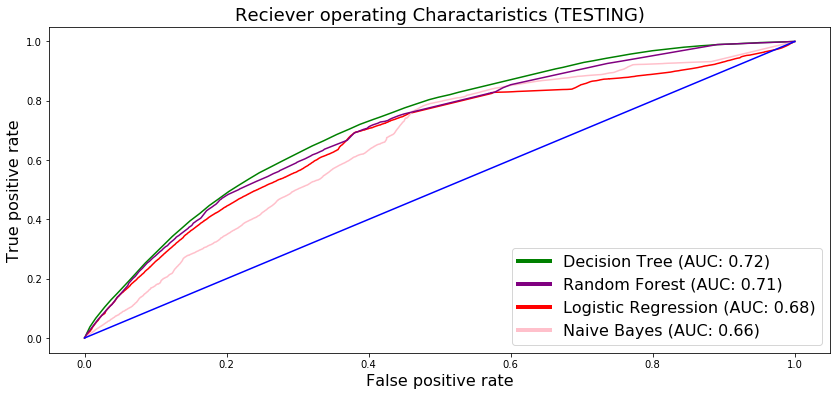

In [81]:
# Predict on Testing Data
X_test = X_test[X_train.columns] #only keep uncorrelated columns

# Logistic Regression
log_reg, fp_logreg, tp_logreg, auc_logreg = calc_roc_stats(mode='test',model=log_reg,X=X_test,y=y_test,verbose=0)

#Decision Tree
tree, fp_dt, tp_dt, auc_dt = calc_roc_stats(mode='test',model=tree,X=X_test,y=y_test,verbose=0)

#Random Forest
rf, fp_rf, tp_rf, auc_rf = calc_roc_stats(mode='test',model=rf,X=X_test,y=y_test,verbose=0)

#Naive Bayes
clf, fp_nb, tp_nb, auc_nb = calc_roc_stats(mode='test',model=clf,X=X_test,y=y_test,verbose=0)

plt.figure(figsize=(14,6))
plt.plot(fp_dt,tp_dt,color='g')
plt.plot(fp_logreg,tp_logreg,color='r')
plt.plot(fp_nb,tp_nb,color='pink')
plt.plot(fp_rf,tp_rf,color='purple')
plt.plot([0,1],[0,1],color='b')
plt.title('Reciever operating Charactaristics (TESTING)', fontsize=18)
plt.xlabel('False positive rate', fontsize=16)
plt.ylabel('True positive rate', fontsize=16)

#custom legend
legend_elements = [Line2D([0], [0], color='g', lw=4, label='Decision Tree (AUC: {:0.2f})'.format(auc_dt)),
                   Line2D([0], [0], color='purple', lw=4, label='Random Forest (AUC: {:0.2f})'.format(auc_rf)),
                   Line2D([0], [0], color='r', lw=4, label='Logistic Regression (AUC: {:0.2f})'.format(auc_logreg)),
                   Line2D([0], [0], color='pink', lw=4, label='Naive Bayes (AUC: {:0.2f})'.format(auc_nb))]
plt.legend(handles=legend_elements,loc='lower right', fontsize=16)

All models are pretty stable and generalize well to unseen test data as witnessed by only slight changes in AUC between train and test sets.

# 5. Discussion

# 6. Submit

In [ ]:
submit = pd.DataFrame({'msno':test['msno'], 'is_churn':y_hat})
submit.to_csv('submission.csv',index=False)